<a href="https://colab.research.google.com/github/Serejechka/vkr_mgtu/blob/main/VKR_Nesmiyanov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import psycopg2 as ps
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from pandas import read_excel, DataFrame, Series
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from numpy.random import seed
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

Загружаем исходные данные из обеих excel таблиц и удаляем колонку с индексом

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
df_bp = pd.read_excel('/content/gdrive/My Drive/X_bp.xlsx', index_col=0)
df_bp.shape


(1023, 10)

In [4]:
df_nup = pd.read_excel('/content/gdrive/My Drive/X_nup.xlsx', index_col=0)
df_nup.shape

(1040, 3)

Рассмотрим списки признаков

In [5]:
pd.DataFrame(df_bp.columns, columns=['Базальтопластик признаки'])

Базальтопластик признаки
0       Соотношение матрица-наполнитель
1                      Плотность, кг/м3
2                 модуль упругости, ГПа
3           Количество отвердителя, м.%
4       Содержание эпоксидных групп,%_2
5              Температура вспышки, С_2
6         Поверхностная плотность, г/м2
7  Модуль упругости при растяжении, ГПа
8         Прочность при растяжении, МПа
9               Потребление смолы, г/м2

In [6]:
pd.DataFrame(df_nup.columns, columns=['Углепластик признаки'])

Углепластик признаки
0   Угол нашивки, град
1          Шаг нашивки
2    Плотность нашивки

В соответствии с заданием это единый набор данных, и он требует объединения по типу INNER (несмотря на разное количество строк в таблицах)

In [7]:
df = df_bp.join(df_nup, how='inner')
df.shape

(1023, 13)

Посмотрим на начальные и конечные строки нашего датасета на данном этапе работы

In [8]:
df

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0                            1.857143       2030.000000   
1                            1.857143       2030.000000   
2                            1.857143       2030.000000   
3                            1.857143       2030.000000   
4                            2.771331       2030.000000   
...                               ...               ...   
1018                         2.271346       1952.087902   
1019                         3.444022       2050.089171   
1020                         3.280604       1972.372865   
1021                         3.705351       2066.799773   
1022                         3.808020       1890.413468   

      модуль упругости, ГПа  Количество отвердителя, м.%  \
0                738.736842                    30.000000   
1                738.736842                    50.000000   
2                738.736842                    49.900000   
3                738.736842                   129.000000   
4                753.000000                   111.860000   
...                     ...                          ...   
1018             912.855545                    86.992183   
1019             444.732634                   145.981978   
1020             416.836524                   110.533477   
1021             741.475517                   141.397963   
1022             417.316232                   129.183416   

      Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                           22.267857                100.000000   
1                           23.750000                284.615385   
2                           33.000000                284.615385   
3                           21.250000                300.000000   
4                           22.267857                284.615385   
...                               ...                       ...   
1018                        20.123249                324.774576   
1019                        19.599769                254.215401   
1020                        23.957502                248.423047   
1021                        19.246945                275.779840   
1022                        27.474763                300.952708   

      Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                        210.000000                             70.000000   
1                        210.000000                             70.000000   
2                        210.000000                             70.000000   
3                        210.000000                             70.000000   
4                        210.000000                             70.000000   
...                             ...                                   ...   
1018                     209.198700                             73.090961   
1019                     350.660830                             72.920827   
1020                     740.142791                             74.734344   
1021                     641.468152                             74.042708   
1022                     758.747882                             74.309704   

      Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0                       3000.000000               220.000000   
1                       3000.000000               220.000000   
2                       3000.000000               220.000000   
3                       3000.000000               220.000000   
4                       3000.000000               220.000000   
...                             ...                      ...   
1018                    2387.292495               125.007669   
1019                    2360.392784               117.730099   
1020                    2662.906040               236.606764   
1021                    2071.715856               197.126067   
1022                    2856.328932               194.754342   

      Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0                 

Просмотрим информацию о датасете, проверим тип данных в каждом столбце (типы признаков)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int64  
 11  Шаг нашивки      

Проверка на пропуски


In [10]:
df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

Количество уникальных значений в каждом столбце


In [11]:
df.nunique()

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

Видим, что признак "Угол нашивки, град" принимает только 2 значения. Можно преобразовать в бинарный признак.

In [12]:
df['Угол нашивки, град'].nunique()

#Проверим кол-во элементов, где Угол нашивки равен 0 градусов
df['Угол нашивки, град'][df['Угол нашивки, град'] == 0.0].count()

# Приведем столбец "Угол нашивки" к значениям 0 и 1 и integer
df = df.replace({'Угол нашивки, град': {0.0 : 0, 90.0 : 1}})
df['Угол нашивки, град'] = df['Угол нашивки, град'].astype(int)

#Переименуем столбец
df = df.rename(columns={'Угол нашивки, град' : 'Угол нашивки'})
df

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0                            1.857143       2030.000000   
1                            1.857143       2030.000000   
2                            1.857143       2030.000000   
3                            1.857143       2030.000000   
4                            2.771331       2030.000000   
...                               ...               ...   
1018                         2.271346       1952.087902   
1019                         3.444022       2050.089171   
1020                         3.280604       1972.372865   
1021                         3.705351       2066.799773   
1022                         3.808020       1890.413468   

      модуль упругости, ГПа  Количество отвердителя, м.%  \
0                738.736842                    30.000000   
1                738.736842                    50.000000   
2                738.736842                    49.900000   
3                738.736842                   129.000000   
4                753.000000                   111.860000   
...                     ...                          ...   
1018             912.855545                    86.992183   
1019             444.732634                   145.981978   
1020             416.836524                   110.533477   
1021             741.475517                   141.397963   
1022             417.316232                   129.183416   

      Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                           22.267857                100.000000   
1                           23.750000                284.615385   
2                           33.000000                284.615385   
3                           21.250000                300.000000   
4                           22.267857                284.615385   
...                               ...                       ...   
1018                        20.123249                324.774576   
1019                        19.599769                254.215401   
1020                        23.957502                248.423047   
1021                        19.246945                275.779840   
1022                        27.474763                300.952708   

      Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                        210.000000                             70.000000   
1                        210.000000                             70.000000   
2                        210.000000                             70.000000   
3                        210.000000                             70.000000   
4                        210.000000                             70.000000   
...                             ...                                   ...   
1018                     209.198700                             73.090961   
1019                     350.660830                             72.920827   
1020                     740.142791                             74.734344   
1021                     641.468152                             74.042708   
1022                     758.747882                             74.309704   

      Прочность при растяжении, МПа  Потребление смолы, г/м2  Угол нашивки  \
0                       3000.000000               220.000000             0   
1                       3000.000000               220.000000             0   
2                       3000.000000               220.000000             0   
3                       3000.000000               220.000000             0   
4                       3000.000000               220.000000             0   
...                             ...                      ...           ...   
1018                    2387.292495               125.007669             1   
1019                    2360.392784               117.730099             1   
1020                    2662.906040               236.606764             1   
1021                    2071.715856               197.126067      

Изучим описательную статистику наших данных (максимальное, минимальное, квартили, медиана, стандартное отклонение, среднее значение и т.д.), посмотрим на основные параметры анализа данных. 

*   count - количество значений
*   mean - среднее значение

*   std - стандартное отклонение
*   min - минимум
*   25% - верхнее значение первого квартиля
*   50% - медиана
*   75% - верхнее значение третьего квартиля
*   max - максимум






In [13]:
a = df.describe()
a.T

count         mean         std  \
Соотношение матрица-наполнитель       1023.0     2.930366    0.913222   
Плотность, кг/м3                      1023.0  1975.734888   73.729231   
модуль упругости, ГПа                 1023.0   739.923233  330.231581   
Количество отвердителя, м.%           1023.0   110.570769   28.295911   
Содержание эпоксидных групп,%_2       1023.0    22.244390    2.406301   
Температура вспышки, С_2              1023.0   285.882151   40.943260   
Поверхностная плотность, г/м2         1023.0   482.731833  281.314690   
Модуль упругости при растяжении, ГПа  1023.0    73.328571    3.118983   
Прочность при растяжении, МПа         1023.0  2466.922843  485.628006   
Потребление смолы, г/м2               1023.0   218.423144   59.735931   
Угол нашивки                          1023.0     0.491691    0.500175   
Шаг нашивки                           1023.0     6.899222    2.563467   
Плотность нашивки                     1023.0    57.153929   12.350969   

                                              min          25%          50%  \
Соотношение матрица-наполнитель          0.389403     2.317887     2.906878   
Плотность, кг/м3                      1731.764635  1924.155467  1977.621657   
модуль упругости, ГПа                    2.436909   500.047452   739.664328   
Количество отвердителя, м.%             17.740275    92.443497   110.564840   
Содержание эпоксидных групп,%_2         14.254985    20.608034    22.230744   
Температура вспышки, С_2               100.000000   259.066528   285.896812   
Поверхностная плотность, г/м2            0.603740   266.816645   451.864365   
Модуль упругости при растяжении, ГПа    64.054061    71.245018    73.268805   
Прочность при растяжении, МПа         1036.856605  2135.850448  2459.524526   
Потребление смолы, г/м2                 33.803026   179.627520   219.198882   
Угол нашивки                             0.000000     0.000000     0.000000   
Шаг нашивки                              0.000000     5.080033     6.916144   
Плотность нашивки                        0.000000    49.799212    57.341920   

                                              75%          max  
Соотношение матрица-наполнитель          3.552660     5.591742  
Плотность, кг/м3                      2021.374375  2207.773481  
модуль упругости, ГПа                  961.812526  1911.536477  
Количество отвердителя, м.%            129.730366   198.953207  
Содержание эпоксидных групп,%_2         23.961934    33.000000  
Температура вспышки, С_2               313.002106   413.273418  
Поверхностная плотность, г/м2          693.225017  1399.542362  
Модуль упругости при растяжении, ГПа    75.356612    82.682051  
Прочность при растяжении, МПа         2767.193119  3848.436732  
Потребление смолы, г/м2                257.481724   414.590628  
Угол нашивки                             1.000000     1.000000  
Шаг нашивки                              8.586293    14.440522  
Плотность нашивки                       64.944961   103.988901

Сохранение объединеного датасета

In [14]:
df.to_excel('/content/gdrive/My Drive/data_joined.xlsx')

Построю графики распределения переменных и "ящики с усами"

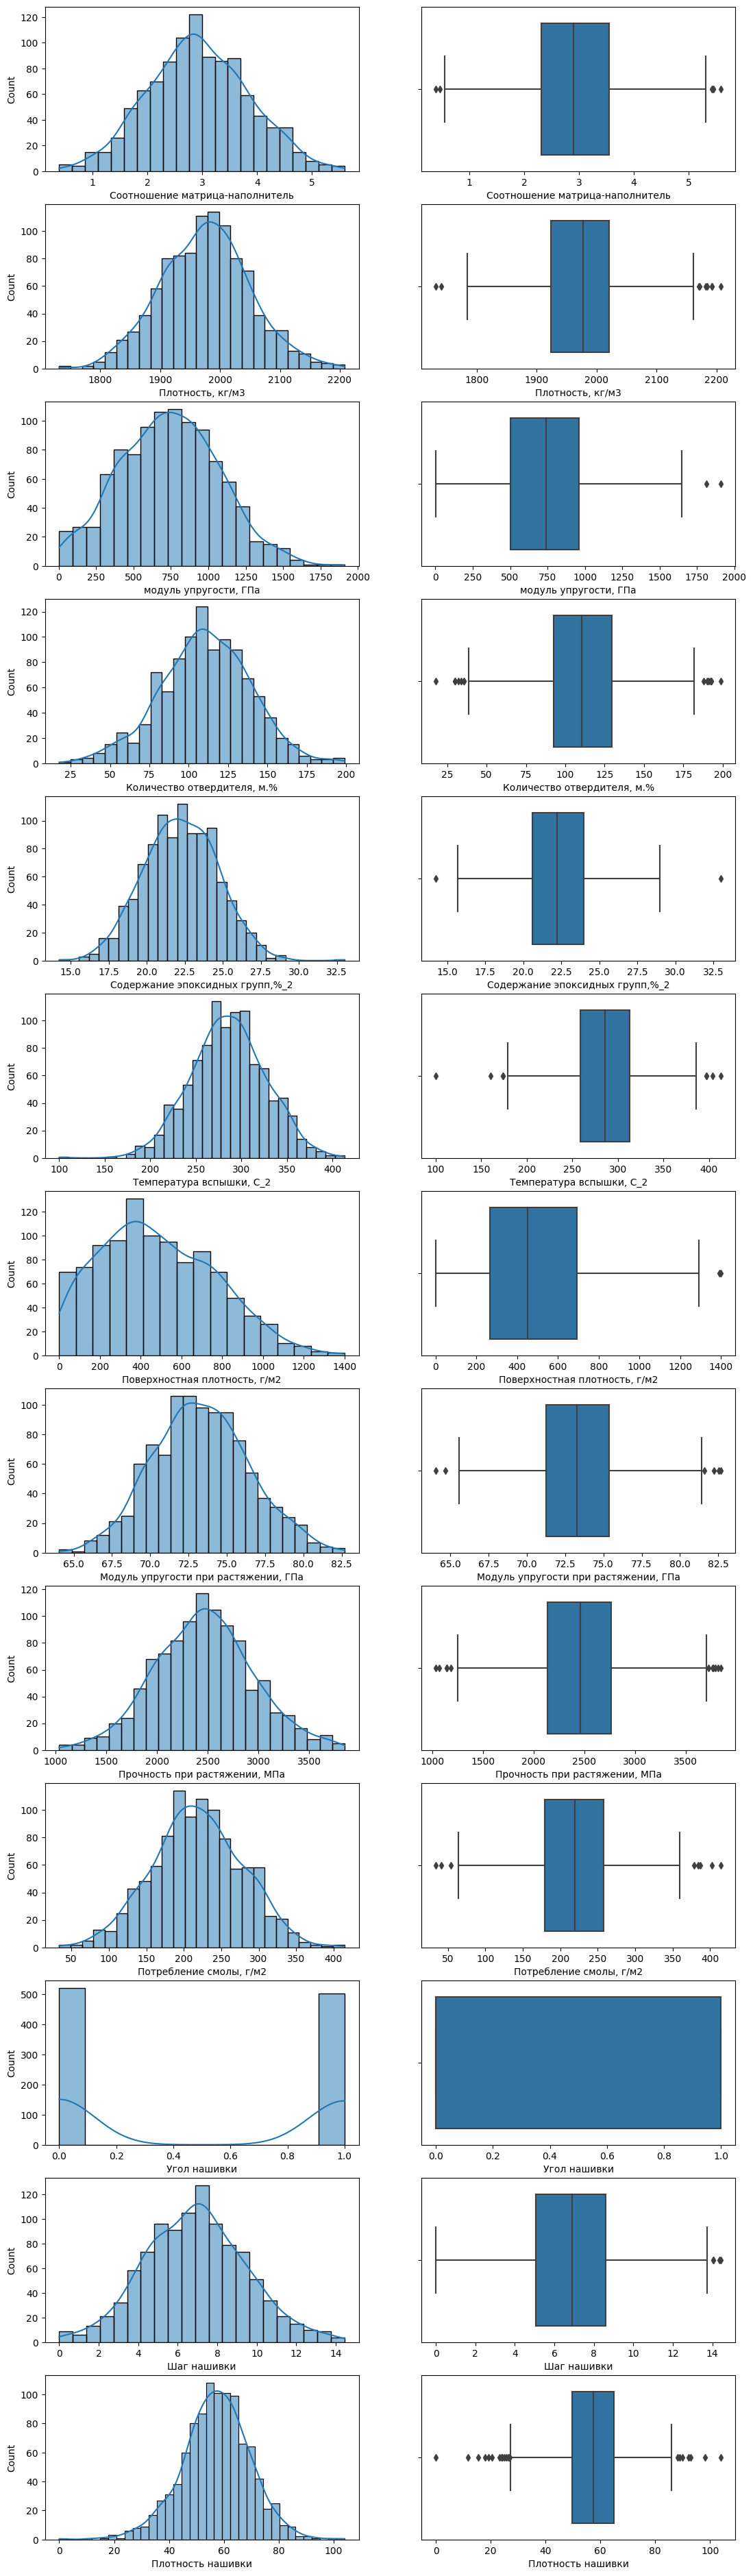

In [15]:
fig, axes = plt.subplots(13, 2, figsize=(13, 48))
for k, column in enumerate(df.columns):    
    sns.histplot(data=df, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=df, x=column, ax=axes[k, 1])
plt.show()

 Преимущественно все данные стремятся к нормальному распределению. Угол нашивки, как и отражено в датасете, имеет только два значения 90 градусов и 0 градусов, что отражает общий подход к проведению нашивки материалов, а также может быть использовано при обработке данных.
 Построю попарные графики рассеяния


In [16]:
sns.pairplot(df, height=3);

По графикам видно, что выбросы есть. Некоторые точки стоят очень далеко от общего облака.
Найду выбросы.
Для поиска выбросов есть разные методы: 3-х сигм или межквартильных расстояний. Экспериментирую, как они отработают на данном наборе данных.

Соотношение матрица-наполнитель: 3s=0 iq=6


Плотность, кг/м3: 3s=3 iq=9


модуль упругости, ГПа: 3s=2 iq=2


Количество отвердителя, м.%: 3s=2 iq=14


Содержание эпоксидных групп,%_2: 3s=2 iq=2


Температура вспышки, С_2: 3s=3 iq=8


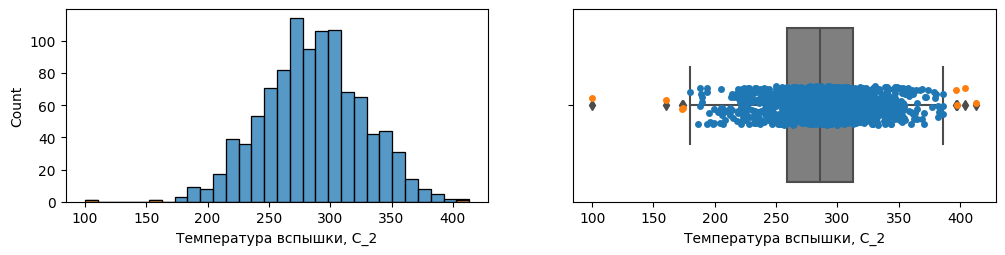

Поверхностная плотность, г/м2: 3s=2 iq=2


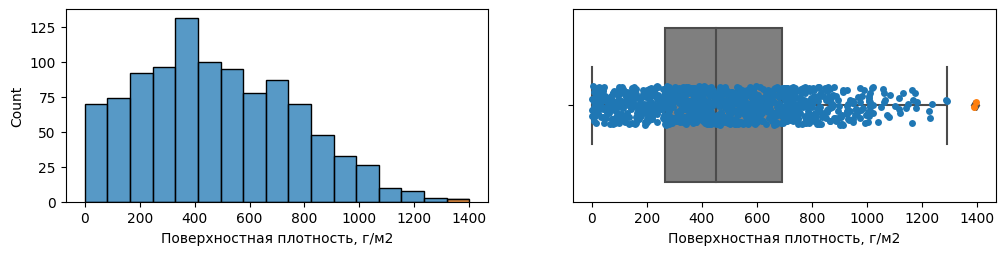

Модуль упругости при растяжении, ГПа: 3s=0 iq=6


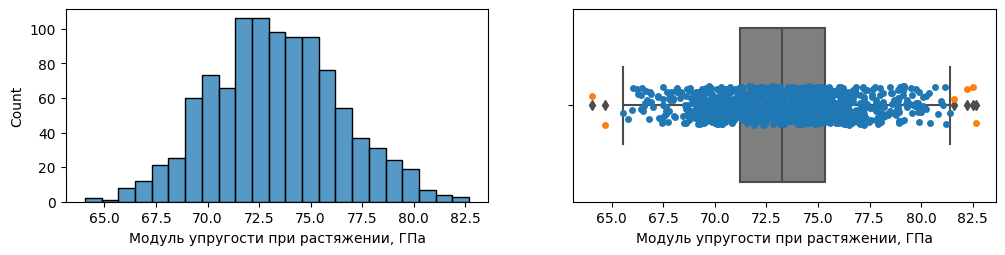

Прочность при растяжении, МПа: 3s=0 iq=11


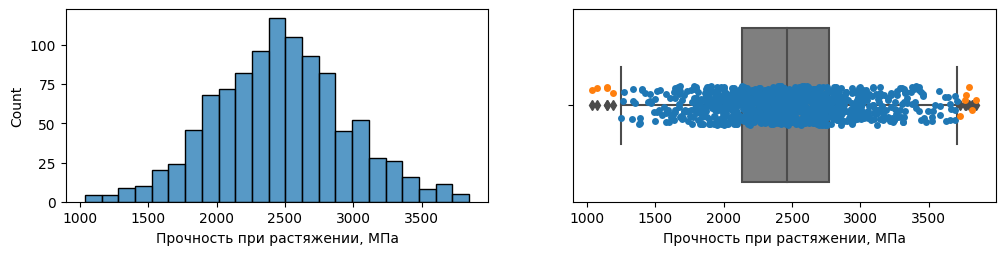

Потребление смолы, г/м2: 3s=3 iq=8


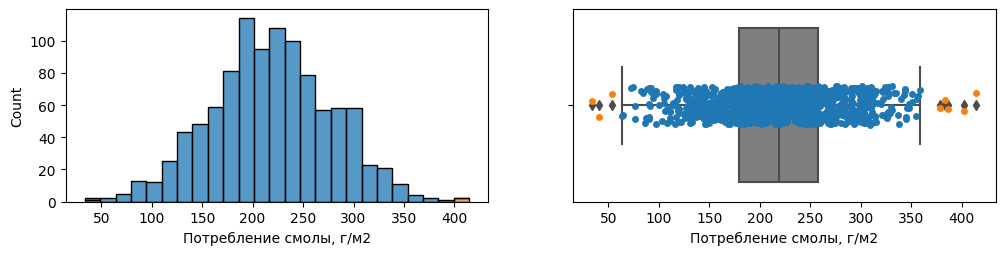

Угол нашивки: 3s=0 iq=0


Шаг нашивки: 3s=0 iq=4


Плотность нашивки: 3s=7 iq=21


Метод 3-х сигм, выбросов: 24
Метод межквартильных расстояний, выбросов: 93


In [18]:
count_3s = 0
count_iq = 0
for column in df:
    d = df.loc[:, [column]]
    # методом 3-х сигм
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    count_3s += d['3s'].sum()
    # методом межквартильных интервалов
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (df[column] <= lower) | (df[column] >= upper)
    count_iq += d['iq'].sum()
    # визуализация выбросов
    print('{}: 3s={} iq={}'.format(column, d['3s'].sum(), d['iq'].sum()))
    fig, axes = plt.subplots(1, 2, figsize=(12, 2.5))
    sns.histplot(data=d, x=column, hue='3s', multiple='stack', legend=False, ax=axes[0])
    sns.boxplot(data=d, x=column, color='tab:gray', ax=axes[1])
    sns.stripplot(data=d[d['iq']==False], x=column, ax=axes[1])
    sns.stripplot(data=d[d['iq']==True], x=column, color='tab:orange', ax=axes[1])
    plt.show()

print('Метод 3-х сигм, выбросов:', count_3s)
print('Метод межквартильных расстояний, выбросов:', count_iq)

В итоге что получилось:
* Метод 3-х сигм, выбросов по всем переменным: 24
* Метод межквартильных расстояний, выбросов по всем переменным: 93

На сырых данных был бы применим метод межквартильных расстояний, чтоб получить более "чистые" данные. Но раз датасет уже очищен от явного шума, применяем метод 3-х сигм, чтобы потерять меньше значимой информации.

In [19]:
outliers = pd.DataFrame(index=df.index)
for column in df:
    zscore = (df[column] - df[column].mean()) / df[column].std()
    outliers[column] = (zscore.abs() > 3)
df = df[outliers.sum(axis=1)==0]
df.shape

(1000, 13)

In [20]:
# сохранение очищенных данных
df.to_excel('/content/gdrive/My Drive/data_cleaned.xlsx')

Смущает то, что по внешнему виду графиков мы не видим никаких зависимостей между признаками. То, что входные переменные независимы друг от друга - это хорошо. Но выходые переменные должны как-то зависеть от входных, чтобы модель могла найти эту зависимость и использовать ее для предсказания. Рассмотрим матрицу корреляции

In [21]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='twilight_shifted', ax=ax)
plt.show()

Коэффициенты корреляции, близкие к 0, показывают отсутствие линейной зависимости между признаками. Предполагаю, что применение линейных моделей регрессии не даст приемлемого результата.

**РАЗДЕЛ 2**

---

Необходимо:
30% данных оставить на тестирование модели, на остальных происходит обучение моделей.
Провести предобработку данных (нормализация и т.д.).
При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении.
Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.

Для каждого из целевых признаков строится отдельная модель
* модуль упругости при растяжении, Гпа (композит) = f(матрица, наполнитель, процесс);
* прочность при растяжении, МПа (композит) = f(матрица, наполнитель, процесс);
* соотношение матрица-наполнитель (процесс) = f(матрица, наполнитель, композит).


In [26]:
# Признаки для модуля упругости
y1_columns = ['Модуль упругости при растяжении, ГПа']
x1_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки', 
  'Шаг нашивки', 
  'Плотность нашивки'
]


In [27]:
y1 = df.loc[:, y1_columns]
x1 = df.loc[:, x1_columns]

In [28]:
# Признаки для прочности при растяжении
y2_columns = ['Прочность при растяжении, МПа']
x2_columns = [
  'Соотношение матрица-наполнитель', 
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Потребление смолы, г/м2',
  'Угол нашивки', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [29]:
y2 = df.loc[:, y2_columns]
x2 = df.loc[:, x2_columns]

In [33]:
# Признаки для соотношения матрица-наполнитель
y3_columns = ['Соотношение матрица-наполнитель']
x3_columns = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

In [34]:
y3 = df.loc[:, y3_columns]
x3 = df.loc[:, x3_columns]

Далее необходимо выполнить препроцессинг. Его необходимо выполнять после разделения на тренировочную и тестовую выборку, как будто мы не знаем параметров тестовой выборки (минимум, максимум, матожидание, стандартное отклонение).
Препроцессинг для категориальных и количественных признаков выполняем по-разному.

Категориальный признак один - 'Угол нашивки, град'. Он принимает значения 0 и 90. Использую OrdinalEncoder, чтобы признак принимал значения 0 и 1.

Вещественных количественных признаков у нас большинство. Можно применить нормализацию (приведение в диапазон от 0 до 1) или стандартизацию (приведение к матожиданию 0, стандартному отклонению 1). Использую стандартизацию и StandardScaler.
Также препроцессинг необходимо повторить в приложении для введенных данных. Поэтому удобно реализовать предварительную обработку с помощью ColumnTransformer. Создам объект preprocessor для каждой из 3-х задач.
Выходные переменные никак не изменяю.